## Machine Learning: Network analysis

### Setup evironment

In [1]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
!pip install sagemaker_pyspark

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e11aff9e-70be-4780-b2ac-0b0a27ed85cd;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 334ms :: artifacts dl 16ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

24/04/29 00:57:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [11]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
# output_prefix_data_submissions = "project/submissions/yyyy=*"
# s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
# print(f"reading submissions from {s3_path}")
# posts = spark.read.parquet(s3_path, header=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [54]:
!aws s3 ls s3://sagemaker-us-east-1-562166416351/project/

                           PRE clean_nlp_data.parquet/
                           PRE clean_topic_data.parquet/
                           PRE comments/
                           PRE data/
                           PRE ml_distinct_article_data.parquet/
                           PRE ml_topic_data.parquet/
                           PRE spark_logs/
                           PRE submissions/


### Load data

In [29]:
# Load data
data_path = "s3a://sagemaker-us-east-1-562166416351/project/ml_distinct_article_data.parquet"
df = spark.read.parquet(data_path)


In [30]:
df.show()

+-------+----------+--------------------+--------------------+-----------------+
|     id|true_count|               label|               title|            topic|
+-------+----------+--------------------+--------------------+-----------------+
|10003zt|         0|no perceived misinfo|Bolivia: New clas...|    emerging tech|
|100063z|         1|   perceived misinfo|N. Korea fires ba...|foriegn relations|
|1001jf1|         0|no perceived misinfo|Iran inspired gov...|   russia&ukraine|
|1001kkm|         0|no perceived misinfo|Zelensky addresse...|   russia&ukraine|
|1001r0t|         0|no perceived misinfo|Russia-backed spa...|   russia&ukraine|
|1002zi7|         0|no perceived misinfo|Iran warned off s...|   russia&ukraine|
|1003rur|         0|no perceived misinfo|Indian leather co...|   russia&ukraine|
|10042wr|         2|   perceived misinfo|Volodymyr Zelensk...|   russia&ukraine|
|10043y9|         0|no perceived misinfo|North Korea fires...|foriegn relations|
|1004cua|         0|no perce

In [33]:
print(df.count())


443996


### Clustering

In [40]:
## Distince topics
unique_topics = df.select("topic").distinct()

DataFrame[topic: string]

In [42]:
unique_topics.show()

+-----------------+
|            topic|
+-----------------+
|    emerging tech|
|     social media|
|   current events|
|            covid|
|   russia&ukraine|
| demographic info|
|         tv shows|
|foriegn relations|
+-----------------+



In [43]:
## Filter irrelevant topics related to politics
df = df.filter(~(df.topic.contains("demographic info") | df.topic.contains("tv shows")))
filtered_unique_topics = df.select("topic").distinct()
filtered_unique_topics.show()

+-----------------+
|            topic|
+-----------------+
|    emerging tech|
|     social media|
|   current events|
|            covid|
|   russia&ukraine|
|foriegn relations|
+-----------------+



In [63]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline

# Tokenization
tokenizer = Tokenizer(inputCol="title", outputCol="words")

# Term Frequency
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)

# Inverse Document Frequency
idf = IDF(inputCol="rawFeatures", outputCol="features_tfidf")

# Pipeline for text processing
text_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
text_model = text_pipeline.fit(df)
df_tfidf = text_model.transform(df)


In [ ]:
# it will be better if we have sentiment score in this analysis

In [65]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# StringIndexer to convert the 'topic' column into indices
indexer = StringIndexer(inputCol="topic", outputCol="topicIndex")
encoder = OneHotEncoder(inputCols=["topicIndex"], outputCols=["topicVec"])

# Pipeline for one-hot encoding
topic_pipeline = Pipeline(stages=[indexer, encoder])
df_encoded = topic_pipeline.fit(df_tfidf).transform(df_tfidf)


In [66]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["features_tfidf", "topicVec"],
    outputCol="features_combined"
)

df_final = assembler.transform(df_encoded)


In [69]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="features_combined", k=5)
model = kmeans.fit(df_final)

# Make predictions
predictions = model.transform(df_final)

# Show results
predictions.printSchema()


root
 |-- id: string (nullable = true)
 |-- true_count: long (nullable = true)
 |-- label: string (nullable = true)
 |-- title: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features_tfidf: vector (nullable = true)
 |-- topicIndex: double (nullable = false)
 |-- topicVec: vector (nullable = true)
 |-- features_combined: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [70]:
from pyspark.ml.feature import PCA

# PCA to reduce dimensions to 2 for visualization
pca = PCA(k=2, inputCol="features_combined", outputCol="features_pca")
model_pca = pca.fit(predictions)
result_pca = model_pca.transform(predictions)

# Selecting only the necessary columns for visualization
df_visual = result_pca.select("id", "features_pca", "prediction")


In [71]:
import pandas as pd

# Convert to Pandas DataFrame
pandas_df = df_visual.toPandas()

# Extract PCA features for plotting
pandas_df['pca_x'] = pandas_df['features_pca'].apply(lambda x: x[0])
pandas_df['pca_y'] = pandas_df['features_pca'].apply(lambda x: x[1])


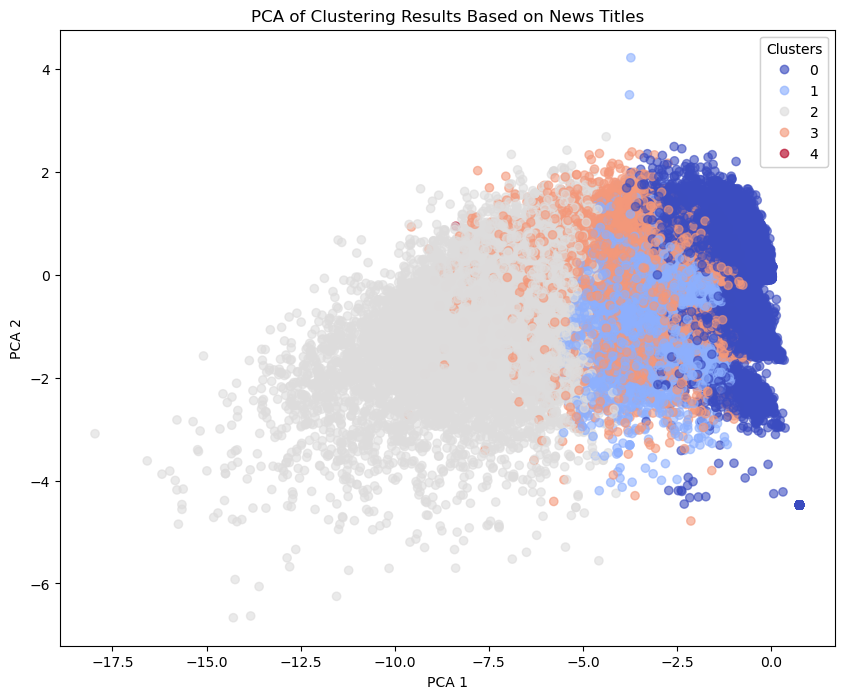

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot colored by cluster labels
scatter = ax.scatter(pandas_df['pca_x'], pandas_df['pca_y'], c=pandas_df['prediction'], cmap='coolwarm', alpha=0.6)

# Legend with cluster labels
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.title('PCA of Clustering Results Based on News Titles')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.savefig('../data/plots/pca_news_title.png', format='png',dpi=400)

plt.show()
